In [1]:
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler

In [2]:
data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)
U=np.load('U.npy')

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)


In [3]:
del spks

(642,)


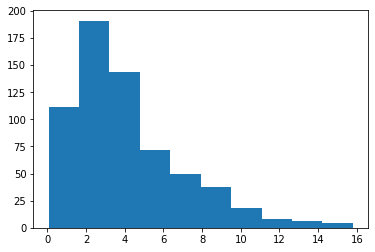

(463,)


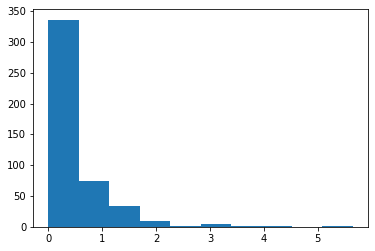

In [39]:
stim_ens_inds=np.nonzero(U[:,13])[0]
print(stim_ens_inds.shape)
stim_k=2.0
stim_theta=2.0
stim_weights=np.random.gamma(shape=stim_k,scale=stim_theta,size=(stim_ens_inds.shape[0],))
plt.hist(stim_weights)
plt.show()

beh_ens_inds=np.nonzero(U[:,8])[0]
print(beh_ens_inds.shape)
beh_k=0.5
beh_theta=1.0
beh_weights=np.random.gamma(shape=beh_k,scale=beh_theta,size=(beh_ens_inds.shape[0],))
plt.hist(beh_weights)
plt.show()


In [40]:
weights=np.hstack((stim_weights,beh_weights))
sc=MinMaxScaler()
weights=sc.fit_transform(weights.reshape(-1,1))
print(weights.shape)

stim_inp=S[stim_ens_inds]
beh_imp=S[beh_ens_inds]
input_patterns=np.vstack((stim_inp,beh_imp))
sc=MinMaxScaler()
input_patterns=sc.fit_transform(input_patterns)

(1105, 1)


(array([585., 220., 143.,  77.,  38.,  22.,  10.,   6.,   2.,   2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

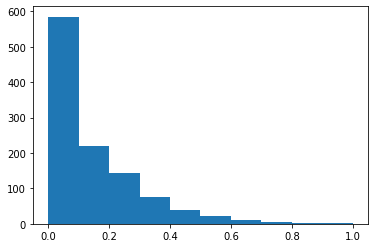

In [6]:
plt.hist(weights)

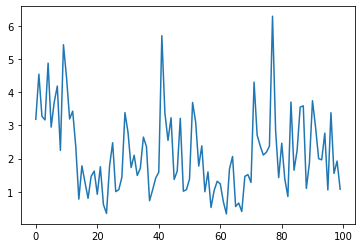

In [7]:
weights=weights.flatten()
v_lst=[np.dot(weights,input_patterns[:,0])]
for j in range(1,30560):
    v_lst.append(np.dot(weights,input_patterns[:,j]))
plt.plot(v_lst[:100])
plt.show()
v_lst=np.array(v_lst)

In [8]:
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest

mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
ly, lx, nstim = mov.shape
#print(nstim)
NT = v_lst.shape[0]
NN=1
mov=mov[:,:,:NT]
print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
#ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ v_lst[itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, 1))
B0 = gaussian_filter(B0, [.5, .5, 0])

30560


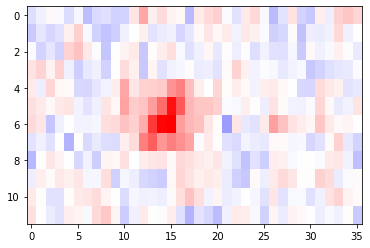

In [9]:
rf = B0[:,:,0]
rfmax = np.max(B0)
# rfmax = np.max(np.abs(rf))
plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax)

(1105, 1)


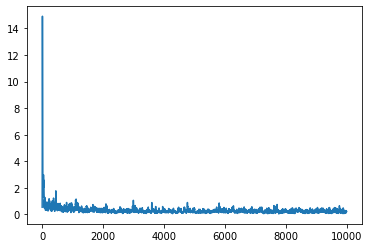

In [41]:

def gain_function(x):
        #x=np.array(x)
        #x[x<0]= 0.5*np.tanh(x[x<0]/0.5)
        '''
        if x<0:
            return 5*np.tanh(x/5)
        else:
            return (100-5)*np.tanh(x/(100-5))
        '''
        #x[x>=0]=(1-0.5)*np.tanh(x[x>=0]/(1.0-0.55))
        return x
    
def update_weights(pre_syn_activity_pattern,post_syn_activity_pattern,W,theta_BCM):
    alpha = 0.1
    #print('syn',pre_syn_activity_pattern.reshape(9479,1)@post_syn_activity_pattern.reshape(1,2))
    #print(alpha*pre_syn_activity_pattern.reshape(1105,1)*post_syn_activity_pattern.reshape(1,)@(post_syn_activity_pattern-theta_BCM))
    #print(W)
    W=W.flatten()
    #print('presyn',pre_syn_activity_pattern.shape)
    W= W+alpha*pre_syn_activity_pattern.flatten()*post_syn_activity_pattern*(post_syn_activity_pattern-theta_BCM)
    W[W<0]=0
    return W
def update_BCM_threshold(theta_BCM,activity_pattern):
    theta_BCM_dt = 1
    BCM_target = 0.2
    theta_BCM += theta_BCM_dt*((activity_pattern/BCM_target)*activity_pattern - theta_BCM)
    return theta_BCM

activity_patterns=input_patterns

print(weights.shape)
theta_BCM = 0.1
rate=np.array([[0]])
h=0.1
theta_lst=[]
weights_lst=[]
tau=1
for t in range(0,10000):
    inpt=weights.flatten()@activity_patterns[:,t].flatten()
    #print('shp',inpt.shape)
    dxdt=(-rate[-1]+gain_function(inpt))/tau
    #print(dxdt)
    rate=np.vstack((rate,(rate[-1]+h*dxdt)))
    weights=update_weights(activity_patterns[:,t],rate[-1],weights,theta_BCM)
    theta_BCM=update_BCM_threshold(theta_BCM,rate[-1])
    theta_lst.append(theta_BCM.item())
    weights_lst.append(weights)
    
plt.plot(theta_lst)
#print(theta_lst)

In [42]:
print(weights)

[4.89675839e-04 2.09580388e-04 2.71327199e-01 ... 6.87434807e-05
 1.55994769e-04 5.62115505e-05]


In [43]:
corr_mat=[]
for j in range(1,9000,100):
    #plt.plot(weights_lst[j])
    #plt.show()
    #print(weights_lst[0])
    #print(np.corrcoef(weights_lst[j],weights_lst[j-1]))
    corr_mat.append(np.corrcoef(weights_lst[j],weights_lst[j-1])[0])
    #plt.show()
np.mean(corr_mat)

0.9999996697145555

In [45]:
v_lst=rate[1:10001].flatten()
print(rate)
v_lst=np.array(zscore(v_lst))
mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
ly, lx, nstim = mov.shape
#print(nstim)
NT = v_lst.shape[0]
NN=1
mov=mov[:,:,:NT]
print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
#ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ v_lst[itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, 1))
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a littleb

[[0.        ]
 [0.32760929]
 [0.78097195]
 ...
 [0.22528389]
 [0.21196039]
 [0.20700981]]
10000


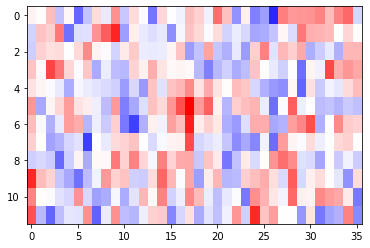

In [46]:

rf = B0[:,:,0]
rfmax = np.max(B0)
# rfmax = np.max(np.abs(rf))
plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax)

(18795, 30560)


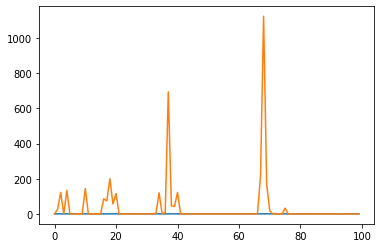

In [47]:
plt.plot(rate[100:200])
print(S.shape)
plt.plot(S[0,100:200])

In [48]:
print(U.shape)
for j in range(18795):
    if U[j,8]!=0 and U[j,13]!=0:
        print(j)

(18795, 50)
7056
9414
13237


In [49]:
print(S.shape)


(18795, 30560)


array([[1.        , 0.00125599],
       [0.00125599, 1.        ]])

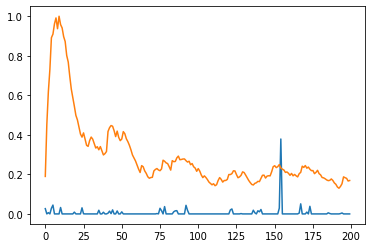

In [50]:
ind=9419
sc=MinMaxScaler()
neuron=sc.fit_transform(S[ind].reshape(-1,1))
rate_=sc.fit_transform(rate.reshape(-1,1))
plt.plot(neuron[0:200])
plt.plot(rate_[1:201])
np.corrcoef(neuron[:10000].flatten(),rate_[1:10001].flatten())

In [ ]:
W=np.load(W)

act (400, 30560)
(200,)


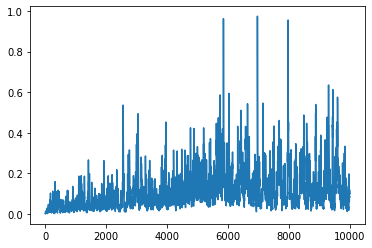

In [56]:
def gain_function(x):
        #x=np.array(x)
        #x[x<0]= 0.5*np.tanh(x[x<0]/0.5)
        '''
        if x<0:
            return 5*np.tanh(x/5)
        else:
            return (100-5)*np.tanh(x/(100-5))
        '''
        #x[x>=0]=(1-0.5)*np.tanh(x[x>=0]/(1.0-0.55))
        return x
    
def update_weights(pre_syn_activity_pattern,post_syn_activity_pattern,W,theta_BCM):
    alpha = 0.1
    #print('syn',pre_syn_activity_pattern.reshape(9479,1)@post_syn_activity_pattern.reshape(1,2))
    #print(alpha*pre_syn_activity_pattern.reshape(1105,1)*post_syn_activity_pattern.reshape(1,)@(post_syn_activity_pattern-theta_BCM))
    #print(W)
    W=W.flatten()
    #print('presyn',pre_syn_activity_pattern.shape)
    W= W+alpha*pre_syn_activity_pattern.flatten()*post_syn_activity_pattern*(post_syn_activity_pattern-theta_BCM)
    W[W<0]=0
    return W
def update_BCM_threshold(theta_BCM,activity_pattern):
    theta_BCM_dt = 1
    BCM_target = 0.2
    theta_BCM += theta_BCM_dt*((activity_pattern/BCM_target)*activity_pattern - theta_BCM)
    return theta_BCM

print('act',activity_patterns.shape)
activity_patterns=input_patterns[0:200,:]

weights=np.load('W.npy')[0,:]
print(weights.shape)
theta_BCM = 0.1
rate=np.array([[0]])
h=0.1
theta_lst=[]
weights_lst=[]
tau=1
for t in range(0,10000):
    inpt=weights.flatten()@activity_patterns[:,t].flatten()
    #print('shp',inpt.shape)
    dxdt=(-rate[-1]+gain_function(inpt))/tau
    #print(dxdt)
    rate=np.vstack((rate,(rate[-1]+h*dxdt)))
    weights=update_weights(activity_patterns[:,t],rate[-1],weights,theta_BCM)
    theta_BCM=update_BCM_threshold(theta_BCM,rate[-1])
    theta_lst.append(theta_BCM.item())
    weights_lst.append(weights)
    
plt.plot(theta_lst)
#print(theta_lst)

In [57]:
v_lst=rate[1:10001].flatten()
print(rate)
v_lst=np.array(zscore(v_lst))
mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
ly, lx, nstim = mov.shape
#print(nstim)
NT = v_lst.shape[0]
NN=1
mov=mov[:,:,:NT]
print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
#ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ v_lst[itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, 1))
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a littleb

[[ 0.        ]
 [-0.01419925]
 [-0.00121569]
 ...
 [ 0.15397736]
 [ 0.14090486]
 [ 0.14140497]]
10000


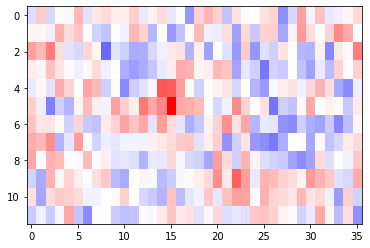

In [58]:

rf = B0[:,:,0]
rfmax = np.max(B0)
# rfmax = np.max(np.abs(rf))
plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax)